<a href="https://colab.research.google.com/github/michaelscheinfeild/unetPytorch/blob/main/DeepLearningwithPyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

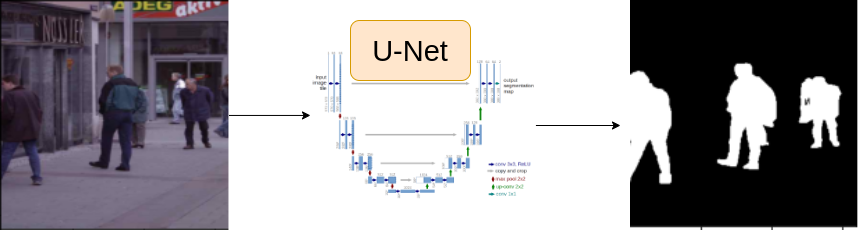

# Some Common Imports

In [2]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [14]:
import random

# Task : 2 Setup Configurations

In [183]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR ='/content/'

DEVICE = 'cuda'

EPOCHS =50
LR = 0.01#0.003
IMAGE_SIZE=320
BATCH_SIZE=32#16

ENCODER = 'efficientnet-b0' #'timm-efficientnet-b0'
WEIGHTS = 'imagenet' # 	imagenet

In [83]:
WEIGHTS

'imagenet'

In [103]:
DEVICE = torch.device("cuda:0")
DEVICE

device(type='cuda', index=0)

In [7]:
df=pd.read_csv(CSV_FILE)
df.head()


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
len(df)

290

In [9]:
row=df.iloc[12]

image_path=row.images
mask_path=row.masks

print(image_path)
print(mask_path)

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

print(image.shape)
print(mask.shape)

Human-Segmentation-Dataset-master/Training_Images/11.jpg
Human-Segmentation-Dataset-master/Ground_Truth/11.png
(168, 299, 3)
(168, 299)


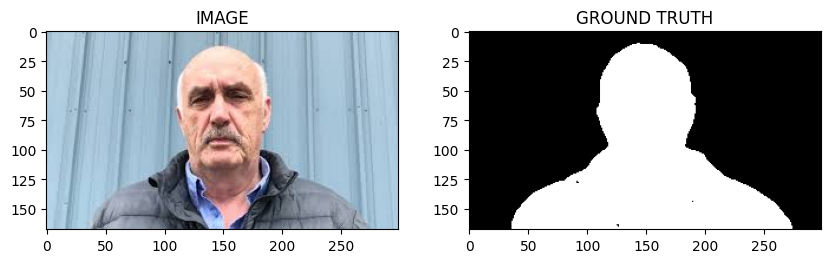

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [11]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
   return A.Compose([
     A.Resize(IMAGE_SIZE,IMAGE_SIZE),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5)])

def get_valid_augs():
  return A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE)])

### check augmentation

In [28]:
# Select randomly 4 rows
random_rows = df.sample(n=4)
random_rows

,masks,images
6,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
209,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
157,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
217,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [19]:
random_rows.__class__

pandas.core.frame.DataFrame

In [20]:
print(random_rows.columns.tolist())

['masks', 'images']


In [27]:
row

'masks'

------------{i}
(195, 259, 3)
(195, 259, 3)
------------{i}
(650, 650, 3)
(650, 650, 3)
------------{i}
(480, 640, 3)
(480, 640, 3)
------------{i}
(145, 348, 3)
(145, 348, 3)


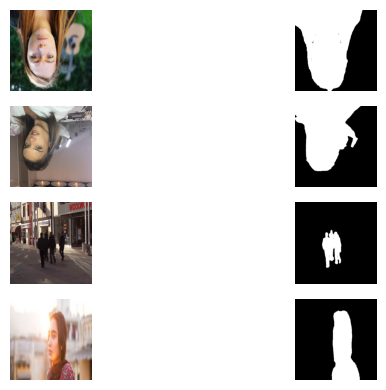

In [35]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 4))

for i, row in enumerate(random_rows.iterrows()):
    _, data = row
    image_path = data['images']
    mask_path = data['masks']

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    # Resize mask to match image size
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    print('------------{i}')
    print(image.shape)
    print(mask.shape)

    aug = get_train_augs()
    augmented = aug(image=image, mask=mask)
    aug_image = augmented['image']
    aug_mask = augmented['mask']

    axes[i, 0].imshow(cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB))
    axes[i, 0].axis('off')
    axes[i, 1].imshow(cv2.cvtColor(aug_mask, cv2.COLOR_BGR2RGB))
    axes[i, 1].axis('off')

plt.tight_layout()

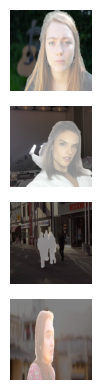

In [39]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 4))

for i, row in enumerate(random_rows.iterrows()):
    _, data = row
    image_path = data['images']
    mask_path = data['masks']

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, 0)  # Read mask as grayscale

    aug = get_train_augs()

    # Resize mask to match image size
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    augmented = aug(image=image, mask=mask)
    aug_image = augmented['image']
    aug_mask = augmented['mask']

    # Convert mask to 3 channels
    aug_mask = cv2.cvtColor(aug_mask, cv2.COLOR_GRAY2BGR)

    # Apply transparency to the mask
    alpha = 0.5  # Set the transparency level (0.0 to 1.0)
    overlay = cv2.addWeighted(aug_image, 1 - alpha, aug_mask, alpha, 0)

    #axes[i, 0].imshow(cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB))
    #axes[i, 0].axis('off')
    axes[i].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

plt.tight_layout()

In [40]:
# Ensure that the mask has the same dimensions as the image
maskR = A.Resize(IMAGE_SIZE, IMAGE_SIZE)(image=mask)["image"]
mimageR = A.Resize(IMAGE_SIZE, IMAGE_SIZE)(image=image)["image"]

In [41]:
maskR.shape

(320, 320)

In [42]:
mimageR.shape

(320, 320, 3)

In [43]:
# Apply augmentation to the image and mask
train_augs = get_train_augs()
augmented = train_augs(image=mimageR, mask=maskR)

# Get the augmented image and mask
augmented_image = augmented['image']
augmented_mask = augmented['mask']

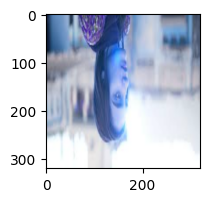

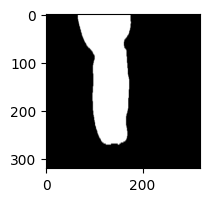

In [44]:
plt.figure(figsize=(2,2))
plt.imshow(augmented_image,cmap='gray')

plt.figure(figsize=(2,2))
plt.imshow(augmented_mask,cmap='gray')

# Task 4 : Create Custom Dataset

In [45]:
from torch.utils.data import Dataset

In [127]:
class SegmentationDataSet(Dataset):

   def __init__(self,df,augmentations):
       self.df = df
       self.augmentations = augmentations

   def __len__(self):
      return len(self.df)

   def __getitem__(self,idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path  = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)#/255.0 #h,w
    mask = np.expand_dims(mask,axis=-1)#h,w,c


    #dictionary
    if (self.augmentations):

      maskR = A.Resize(IMAGE_SIZE, IMAGE_SIZE)(image=mask)["image"]
      mimageR = A.Resize(IMAGE_SIZE, IMAGE_SIZE)(image=image)["image"]

      augmented = self.augmentations(image=mimageR,mask=maskR)

      augmentedImage = augmented['image']
      augmentedMask = augmented['mask']

      #(h,w,c)-> (c,w,h)

      augmentedImage = np.transpose( augmentedImage,(2, 0, 1)).astype(np.float32)
      augmentedMask = np.transpose(augmentedMask,(2, 0, 1)).astype(np.float32)

      augmentedImage = torch.Tensor(augmentedImage)/255.0
      augmentedMask  = torch.round(torch.Tensor(augmentedMask)/255.0)

      #augmentedImage = augmentedImage.to(DEVICE)
      #augmentedMask = augmentedMask.to(DEVICE)

      return augmentedImage,augmentedMask



trainset =SegmentationDataSet(train_df, get_train_augs())
validset =SegmentationDataSet(valid_df, get_valid_augs())

In [116]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


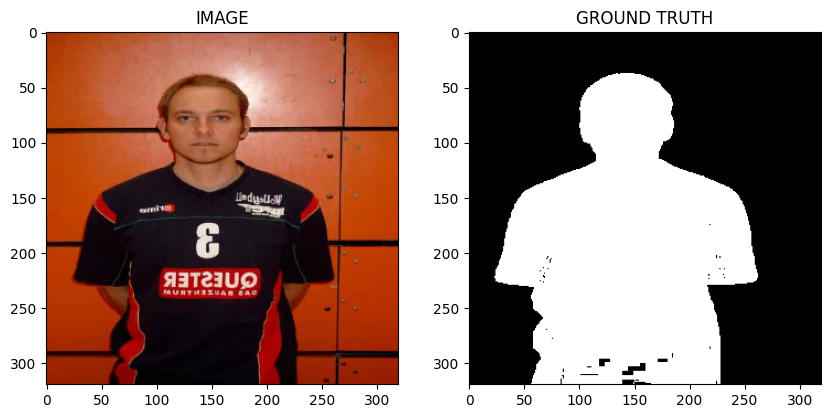

In [128]:
idx=12
image,mask=trainset[idx]
#print(image.shape)
#print(mask.shape)
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [49]:
from torch.utils.data import DataLoader

In [129]:
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validationloader = DataLoader(validset,batch_size=BATCH_SIZE)

In [120]:
print(f"batches train:{len(trainloader)}")
print(f"batches validation:{len(validationloader )}")

batches train:15
batches validation:4


In [130]:
for imageb,maskb in trainloader:
  break

print(f"image batch:{imageb.shape}")
print(f"mask batch:{maskb.shape}")

image batch:torch.Size([16, 3, 320, 320])
mask batch:torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

https://segmentation-modelspytorch.readthedocs.io/en/latest/

- The Dice Loss is particularly useful for imbalanced datasets where the background class dominates the foreground class
* Dice = (2 * TP) / (2 * TP + FP + FN)

* Dice Loss = 1 - Dice
* In the case of multi-class segmentation, you calculate the Dice coefficient for each class separately and average them

In [62]:
!pip install torch


In [131]:
#import torch as nn
import torch.nn as nn
#import segmentation_models as smp
import segmentation_models_pytorch as smp

#from segmentation_models.losses import Diceloss


In [132]:
from segmentation_models_pytorch.losses  import DiceLoss

In [133]:
class SegmentationModel(nn.Module): #nn.Module
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None #output logit
    )

  def forward(self, images, masks=None):

    logits = self.arc(images)

    loss1=DiceLoss(mode='binary')(logits,masks)
    loss2=nn.BCEWithLogitsLoss()(logits,masks)
    return logits,loss1+loss2

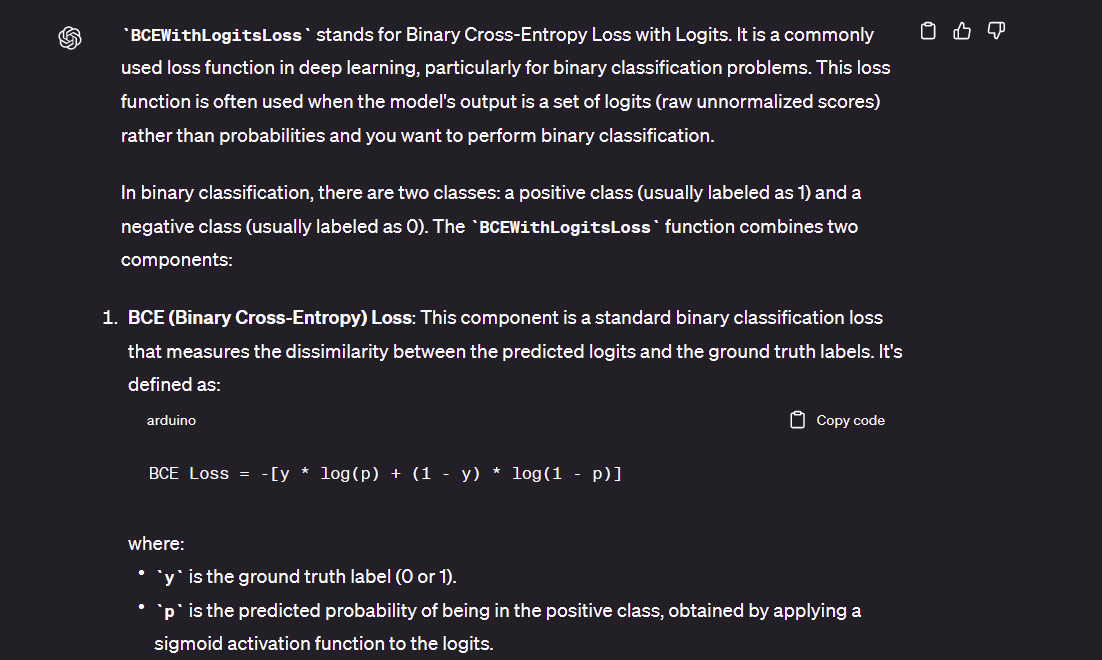

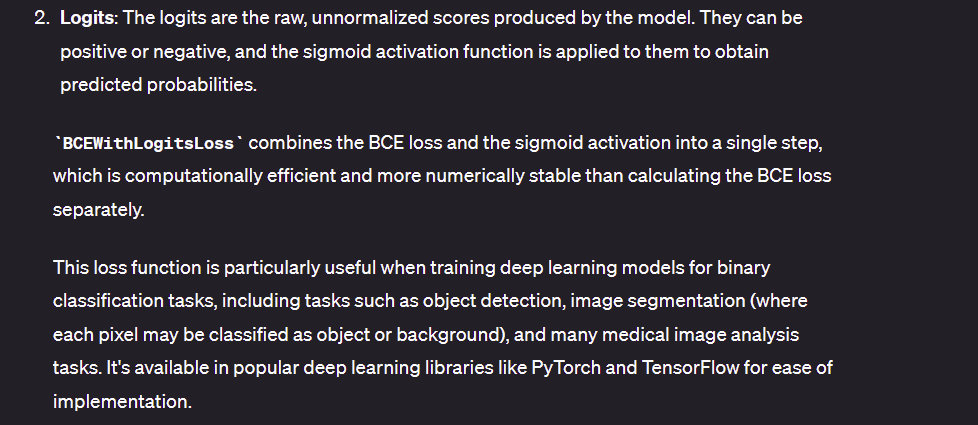

In [184]:
model=SegmentationModel()
model.to(DEVICE)


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): I

# Task 7 : Create Train and Validation Function

In [135]:
def train_fn(data_loader, model, optimizer):

    model.train()
    total_loss = 0.0

    for images, masks in data_loader:

        images=images.to(DEVICE)
        masks=masks.to(DEVICE)

        optimizer.zero_grad()

        logits,loss = model(images,masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

In [136]:
def eval_fn(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
      for images, masks in data_loader:

          images=images.to(DEVICE)
          masks=masks.to(DEVICE)

          logits,loss = model(images,masks)

          total_loss += loss.item()

    return total_loss/len(data_loader)

# Task 8 : Train Model

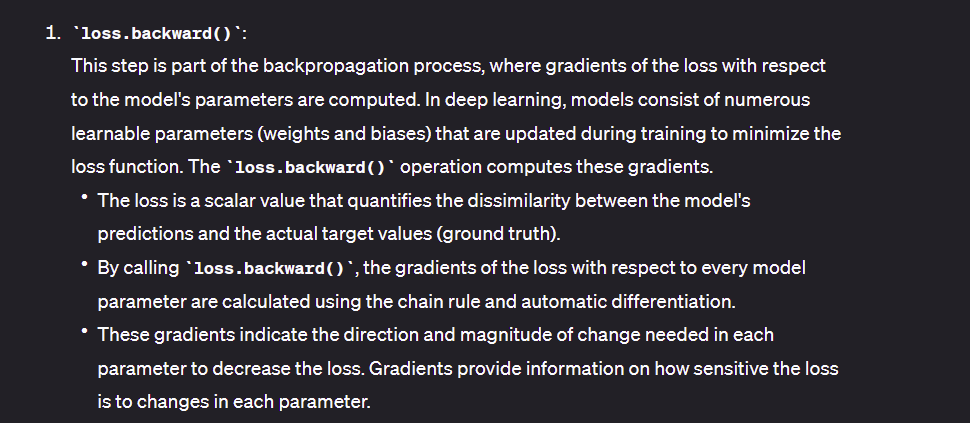

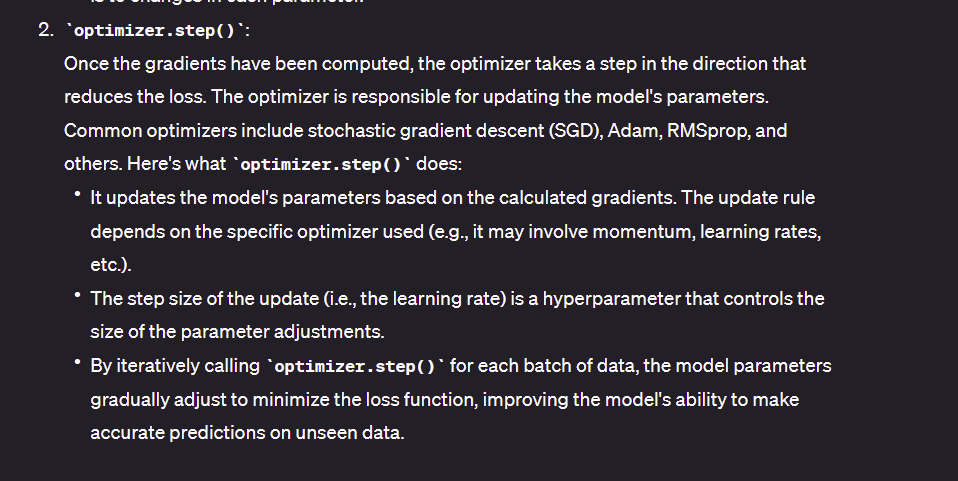

In [185]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)


In [92]:
def calculate_accuracy(logits, masks):
    # Apply a threshold to the logits to get binary predictions (0 or 1)
    binary_predictions = (logits > 0).float()  # Adjust the threshold as needed

    # Calculate accuracy by comparing predictions to ground truth masks
    correct_predictions = (binary_predictions == masks).float()
    accuracy = correct_predictions.mean().item()
    return accuracy

In [138]:
for images, masks in trainloader:
  break

In [139]:
images.shape

torch.Size([16, 3, 320, 320])

In [140]:
if image.device.type == 'cpu':
    print("Image is on the CPU.")
else:
    print("Image is on the GPU.")

Image is on the CPU.


In [142]:
# Check if the model is on the GPU
is_model_on_gpu = next(model.parameters()).is_cuda
if is_model_on_gpu:
    print("Model is on the GPU.")
else:
    print("Model is on the CPU.")

Model is on the GPU.


In [102]:
DEVICE

'cuda'

In [186]:
best_valid_loss = np.inf
#train_losses = []
#valid_losses = []
#train_accuracies = []
#valid_accuracies = []

for i in range(EPOCHS):
    train_loss =  train_fn(trainloader,model,optimizer) #moves inside images to device
    valid_loss  = eval_fn(validationloader,model)

    #train_losses.append(train_loss)
    #valid_losses.append(valid_loss)


    #train_accuracy = 0.0
    #for images, masks in trainloader:
    #    logits, _ = model(images)   #move to device
    #    train_accuracy += calculate_accuracy(logits, masks)
    #train_accuracy /= len(trainloader)

    # Calculate validation accuracy
    #valid_accuracy = 0.0
    #for images, masks in validationloader:
    #    logits, _ = model(images)
    #    valid_accuracy += calculate_accuracy(logits, masks)
    #valid_accuracy /= len(validationloader)


    #train_accuracies.append(train_accuracy)
    #valid_accuracies.append(valid_accuracy)

    if(valid_loss<best_valid_loss):
      torch.save(model.state_dict(),'best_model.pt')
      print("saved_model")
      best_valid_loss = valid_loss

    print(f"Epoch: {i}  , train_loss: {train_loss}  , valid_loss: {valid_loss}")

saved_model
Epoch: 0  , train_loss: 1.0243022799491883  , valid_loss: 30784.96142578125
Epoch: 1  , train_loss: 0.6867994427680969  , valid_loss: 472910.9453125
Epoch: 2  , train_loss: 0.592080815633138  , valid_loss: 47624.1044921875
saved_model
Epoch: 3  , train_loss: 0.5454200625419616  , valid_loss: 1166.4785919189453
saved_model
Epoch: 4  , train_loss: 0.40804936091105143  , valid_loss: 90.04526901245117
saved_model
Epoch: 5  , train_loss: 0.42331309119860333  , valid_loss: 25.23774766921997
Epoch: 6  , train_loss: 0.42755342920621237  , valid_loss: 31.724353313446045
saved_model
Epoch: 7  , train_loss: 0.38195486068725587  , valid_loss: 17.183157444000244
saved_model
Epoch: 8  , train_loss: 0.37660475869973503  , valid_loss: 2.627982199192047
saved_model
Epoch: 9  , train_loss: 0.3181942711273829  , valid_loss: 2.0789230167865753
saved_model
Epoch: 10  , train_loss: 0.32683588365713756  , valid_loss: 1.8742671310901642
saved_model
Epoch: 11  , train_loss: 0.3014326085646947  , va

# Task 9 : Inference

In [187]:
model.load_state_dict(torch.load('best_model.pt'))

idx=20
image,mask=validset[idx]


In [188]:
model

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): I

In [189]:
# Check if the model is on the GPU
is_model_on_gpu = next(model.parameters()).is_cuda
if is_model_on_gpu:
    print("Model is on the GPU.")
else:
    print("Model is on the CPU.")

Model is on the GPU.


In [190]:
mask.shape

torch.Size([1, 320, 320])

In [191]:
image.shape

torch.Size([3, 320, 320])

In [192]:
imgD = image.to(DEVICE).unsqueeze(0)
print(imgD.shape)
print(imgD.__class__)

torch.Size([1, 3, 320, 320])
<class 'torch.Tensor'>


In [193]:
if imgD.device.type == 'cpu':
    print("Image is on the CPU.")
else:
    print("Image is on the GPU.")

Image is on the GPU.


In [176]:
#logits_mask=model(imgD)#(c,h,w)->(1,c,h,w)

In [194]:

#pred_mask  =torch.sigmoid(logits_mask)
#pred_mask  =(pred_mask>0.5)*1.0

#helpre.show_image(image, mask, pred_mask.detach.cpu().squeeze(0))

In [195]:
model.eval()

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): I

In [196]:
with torch.no_grad():
      for images, masks in validationloader:

          images=images.to(DEVICE)
          masks=masks.to(DEVICE)

          logits,loss = model(images,masks)
          break

In [197]:
loss

tensor(0.1319, device='cuda:0')

In [198]:
images.shape

torch.Size([16, 3, 320, 320])

In [199]:
masks.shape

torch.Size([16, 1, 320, 320])

In [181]:
logits.shape

torch.Size([16, 1, 320, 320])

<ipython-input-200-582f7cd05021>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

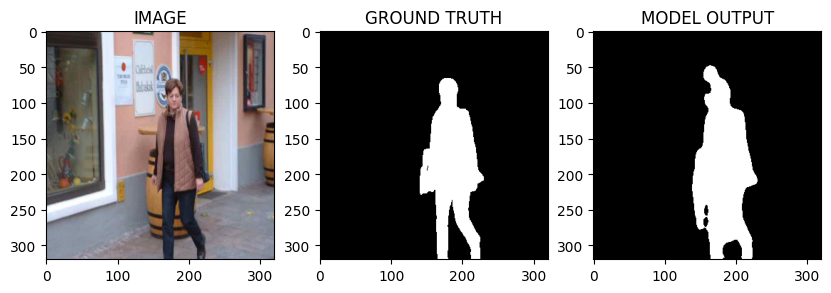

<Figure size 640x480 with 0 Axes>

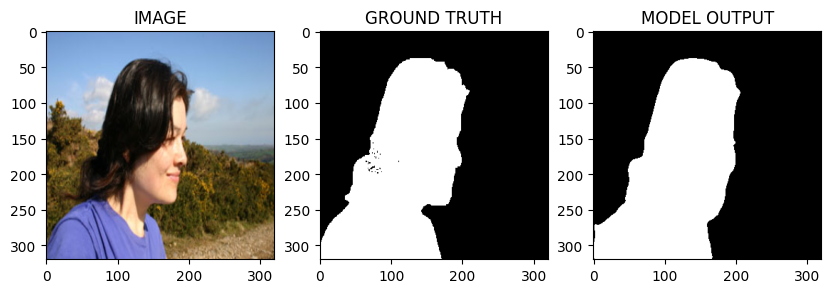

<Figure size 640x480 with 0 Axes>

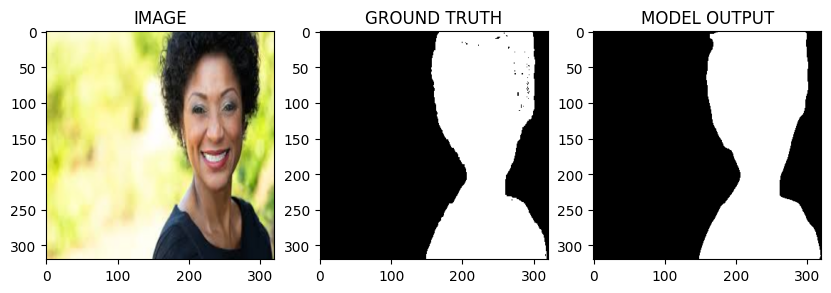

<Figure size 640x480 with 0 Axes>

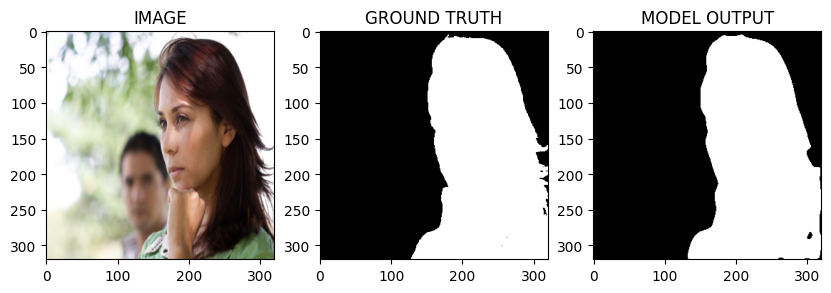

<Figure size 640x480 with 0 Axes>

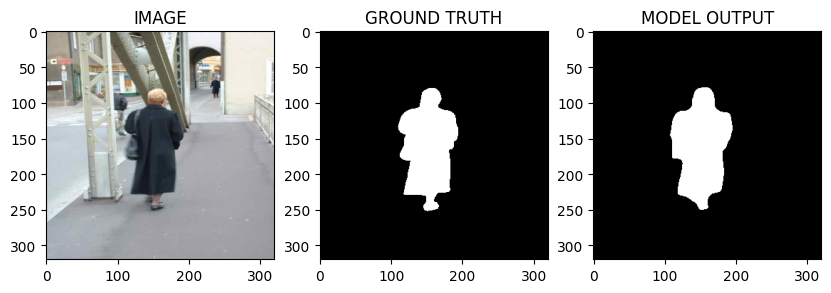

<Figure size 640x480 with 0 Axes>

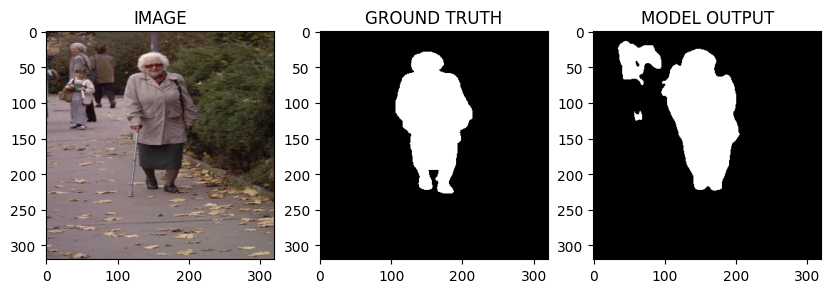

<Figure size 640x480 with 0 Axes>

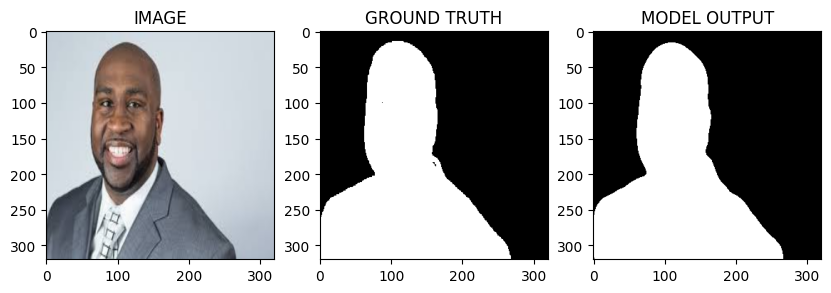

<Figure size 640x480 with 0 Axes>

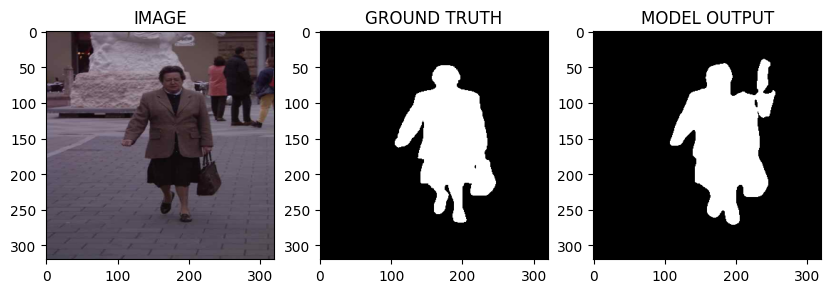

<Figure size 640x480 with 0 Axes>

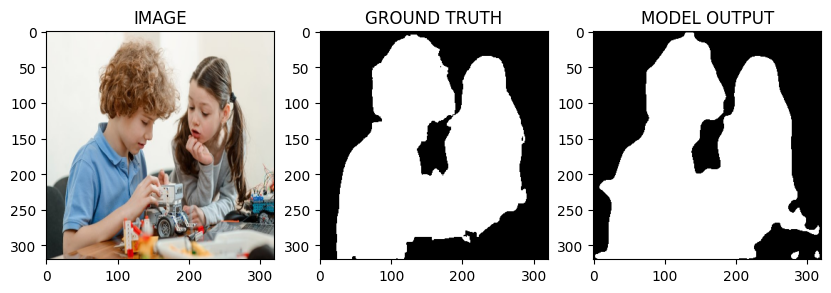

<Figure size 640x480 with 0 Axes>

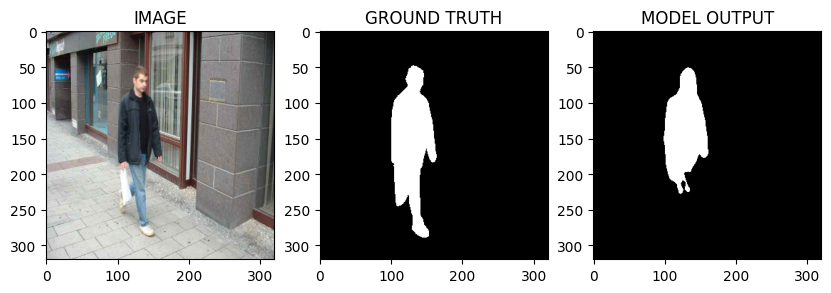

<Figure size 640x480 with 0 Axes>

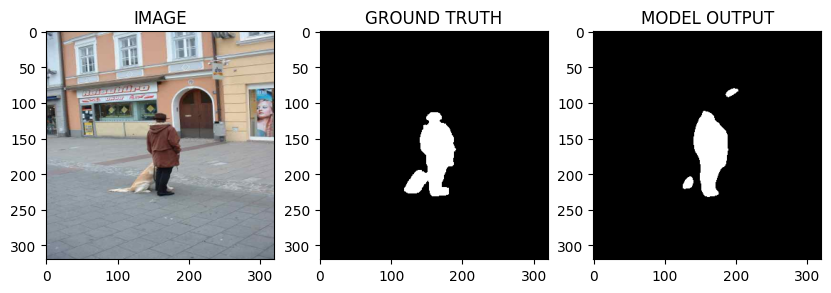

<Figure size 640x480 with 0 Axes>

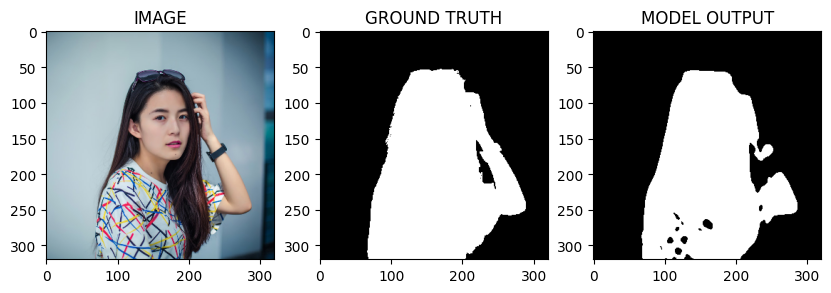

<Figure size 640x480 with 0 Axes>

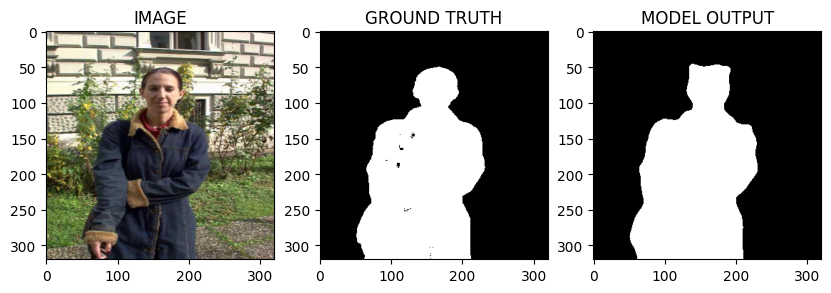

<Figure size 640x480 with 0 Axes>

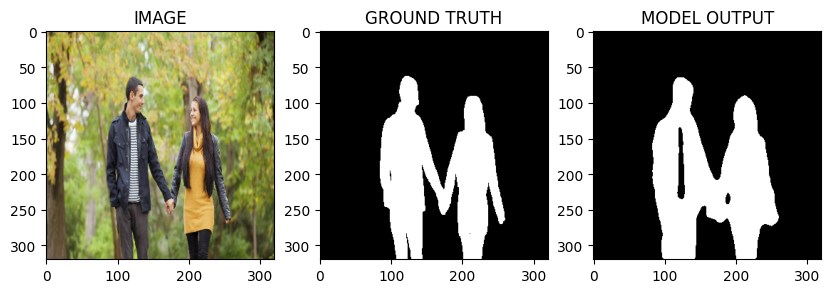

<Figure size 640x480 with 0 Axes>

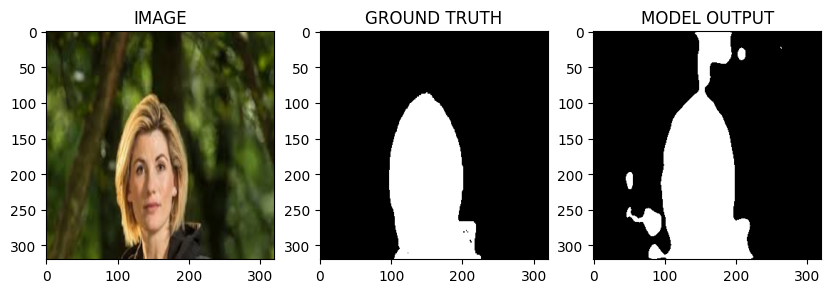

<Figure size 640x480 with 0 Axes>

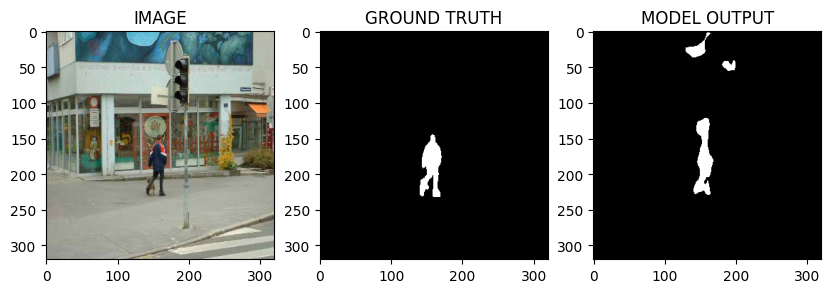

In [200]:
for i in range(16):
    plt.figure()
    img_cpu = images[i].cpu()
    mask_cpu = masks[i].cpu()
    logits_mask_cpu = logits[i].cpu()

    pred_mask = torch.sigmoid(logits_mask_cpu)
    pred_mask = (pred_mask > 0.5).float()

    # Perform some operations with img_cpu, mask_cpu, and pred_mask on the CPU
    # For example, you can call a function with these tensors
    helper.show_image(img_cpu, mask_cpu, pred_mask)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

Modified By Michael Scheinfeild in coursera course